In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import random, os, shutil, string
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing import text, sequence
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import *

In [19]:
classes = 62
im_side = 128

In [20]:
df = pd.read_csv(
    "english.csv",
    dtype={"image": pd.StringDtype(), "label": pd.CategoricalDtype()}
)

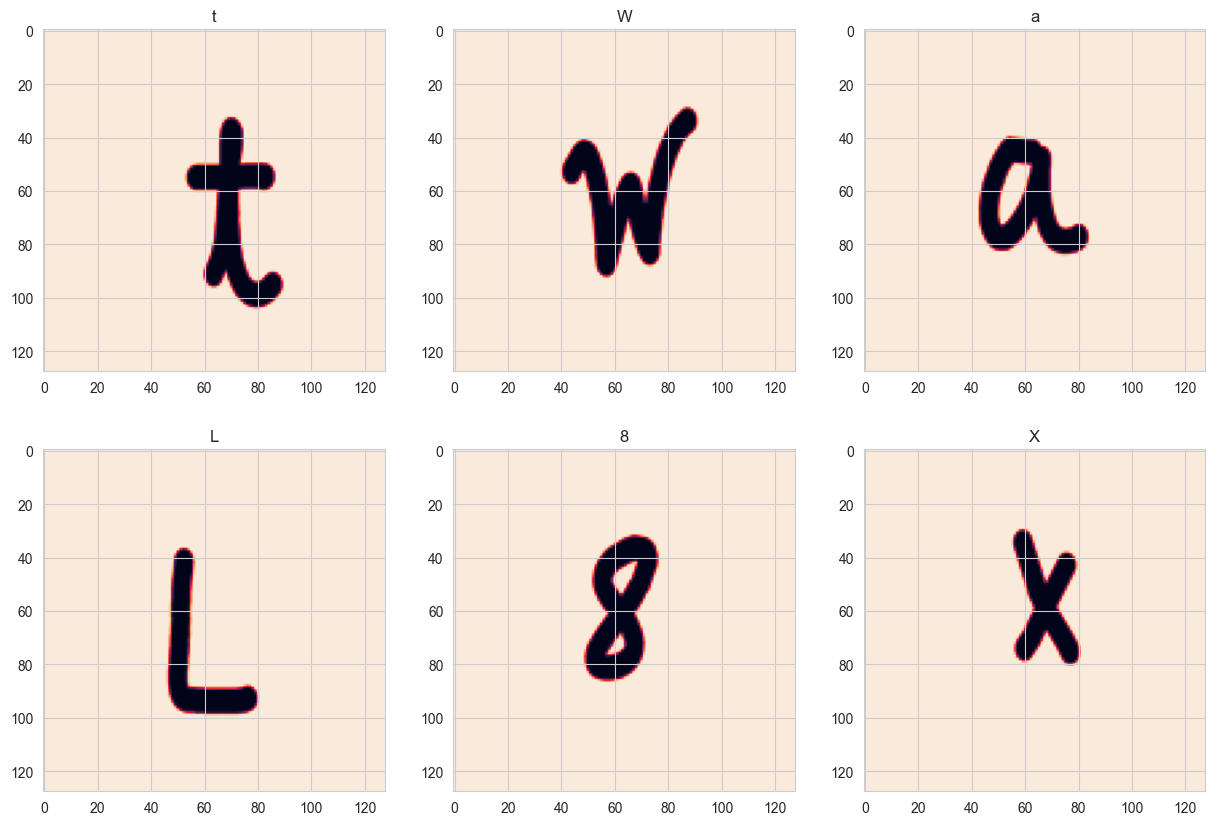

In [21]:
plt.figure(figsize=(15, 10))
for i, idx in enumerate(np.array(df.sample(6))):
    img = Image.open(idx[0])
    img = img.convert("L")
    img = img.resize((im_side, im_side))
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(idx[1])
plt.show()

In [22]:
labels = df.loc[:, "label"].values

In [23]:
images = []
for i in df.loc[:, "image"].values:
    img = Image.open(i)
    img = img.convert("L")
    img = img.resize((im_side, im_side))
    images.append(np.array(img))

In [24]:
images = np.array(images) / 255.

In [25]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True, lower=False)
tokenizer.fit_on_texts(labels)

# Convert text data to sequences
text_sequences = tokenizer.texts_to_sequences(labels)

# Padding sequences for a consistent input size
max_text_length = max(len(seq) for seq in text_sequences)
padded_text_sequences = tf.keras.preprocessing.sequence.pad_sequences(text_sequences, maxlen=max_text_length)

In [26]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50))
model.add(LSTM(1024))
model.add(Dense(im_side * im_side, activation='exponential'))
model.add(Reshape((im_side, im_side, 1)))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
model.fit(np.array(padded_text_sequences), images, epochs=300, batch_size=64)

Epoch 1/300
54/54 [==============================] - 6s 107ms/step - loss: 0.0355
Epoch 2/300
54/54 [==============================] - 6s 110ms/step - loss: 0.0355
Epoch 3/300
54/54 [==============================] - 6s 110ms/step - loss: 0.0354
Epoch 4/300
54/54 [==============================] - 6s 115ms/step - loss: 0.0354
Epoch 5/300
54/54 [==============================] - 6s 112ms/step - loss: 0.0354
Epoch 6/300
54/54 [==============================] - 6s 112ms/step - loss: 0.0354
Epoch 7/300
54/54 [==============================] - 6s 112ms/step - loss: 0.0354
Epoch 8/300
54/54 [==============================] - 6s 114ms/step - loss: 0.0354
Epoch 9/300
54/54 [==============================] - 6s 110ms/step - loss: 0.0354
Epoch 10/300
54/54 [==============================] - 6s 113ms/step - loss: 0.0354
Epoch 11/300
54/54 [==============================] - 6s 107ms/step - loss: 0.0354
Epoch 12/300
54/54 [==============================] - 6s 108ms/step - loss: 0.0354
Epoch 13/300


In [41]:
model.save("char2handI")

INFO:tensorflow:Assets written to: char2handI\assets


INFO:tensorflow:Assets written to: char2handI\assets


In [29]:
model = load_model("char2handI")

In [30]:
def delete_directory(directory_path):
    try:
        # Remove the contents of the directory
        for root, dirs, files in os.walk(directory_path):
            for file in files:
                file_path = os.path.join(root, file)
                os.remove(file_path)
            for dir in dirs:
                dir_path = os.path.join(root, dir)
                os.rmdir(dir_path)

        # Now, remove the empty directory
        shutil.rmtree(directory_path)

        print(f"Directory '{directory_path}' already exists, '{directory_path}' deleted successfully.")
    except Exception as e:
        print("does not exists")

In [33]:
def get_out_image(text="Sample", figsize=(10, 6), crop_size=(im_side // 2, im_side)):
    mystr = text
    textlist = [i for i in text if i in (string.ascii_letters + string.digits + " \n")]

    max_length = max([len(i) for i in text.split("\n")])

    predicted_images = []

    for new_text in textlist:
        if new_text == " ":
            white_image = np.ones((im_side, im_side)) * 249
            predicted_images.append(white_image)
        elif new_text == "\n":
            predicted_images.append(np.zeros((im_side, im_side)) * 249)
        else:
            new_text_sequence = tokenizer.texts_to_sequences([new_text])
            predicted_image = model.predict(np.array(new_text_sequence), verbose=5)[0]
            predicted_image = predicted_image.reshape(im_side, im_side)
            predicted_images.append(predicted_image)

    directory_path = 'out_images'
    delete_directory(directory_path)

    import os
    os.mkdir("out_images")

    predicted_images = np.array(predicted_images)

    for new_text, image in zip(textlist, predicted_images):
        image_path = f"out_images/{new_text}.png"
        fig = plt.figure(figsize=(im_side/100, im_side/100))
        if new_text == " ":
            fig.figimage(image, vmin=0, vmax=255)
        elif new_text == "\n":
            plt.close(fig)
            continue
        else:
            fig.figimage(image)
        plt.savefig(image_path)
        plt.close(fig)

    def center_crop(image, target_size):
        width, height = image.size
        left = (width - target_size[0]) // 2
        top = (height - target_size[1]) // 2
        right = (width + target_size[0]) // 2
        bottom = (height + target_size[1]) // 2
        return image.crop((left, top, right, bottom))

    def merge_images(image_list):
        return Image.fromarray(np.hstack(image_list))

    def merge_lines(line_list):
        image_size = line_list[0].size
        merged_image = np.zeros((len(line_list) * image_size[1], image_size[0]))

        for i, image in enumerate(line_list):
            merged_image[i * image_size[1]:(i + 1) * image_size[1], :] = np.array(image)
        return merged_image

    space_img_path = f"out_images/ .png"
    space_img = Image.open(space_img_path).convert("L")  # Convert to grayscale
    space_img = center_crop(space_img, target_size=crop_size)  # Adjust the target size as needed

    # Load images and center crop
    lines = []
    images = []
    for char in textlist:
        if char == "\n":
            images.extend([space_img] * (max_length - len(images)))
            lines.append(merge_images(images))
            images.clear()
            continue
        # Load image (replace 'path_to_images' with the actual path)
        image_path = f"out_images/{char}.png"
        img = Image.open(image_path).convert("L")  # Convert to grayscale
        cropped_img = center_crop(img, target_size=crop_size)  # Adjust the target size as needed
        images.append(cropped_img)

    # Merge images into a single numpy array
    if images:
        images.extend([space_img] * (max_length - len(images)))
        lines.append(merge_images(images))
        images.clear()
    merged_line_array = merge_lines(lines)
    Image.fromarray(merged_line_array).convert("L").save("final.jpg")

    # Display the thresholded merged image
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(merged_line_array, cmap="gray", vmin=0, vmax=255)
    ax.axis("off")
    plt.show()

Directory 'out_images' already exists, 'out_images' deleted successfully.


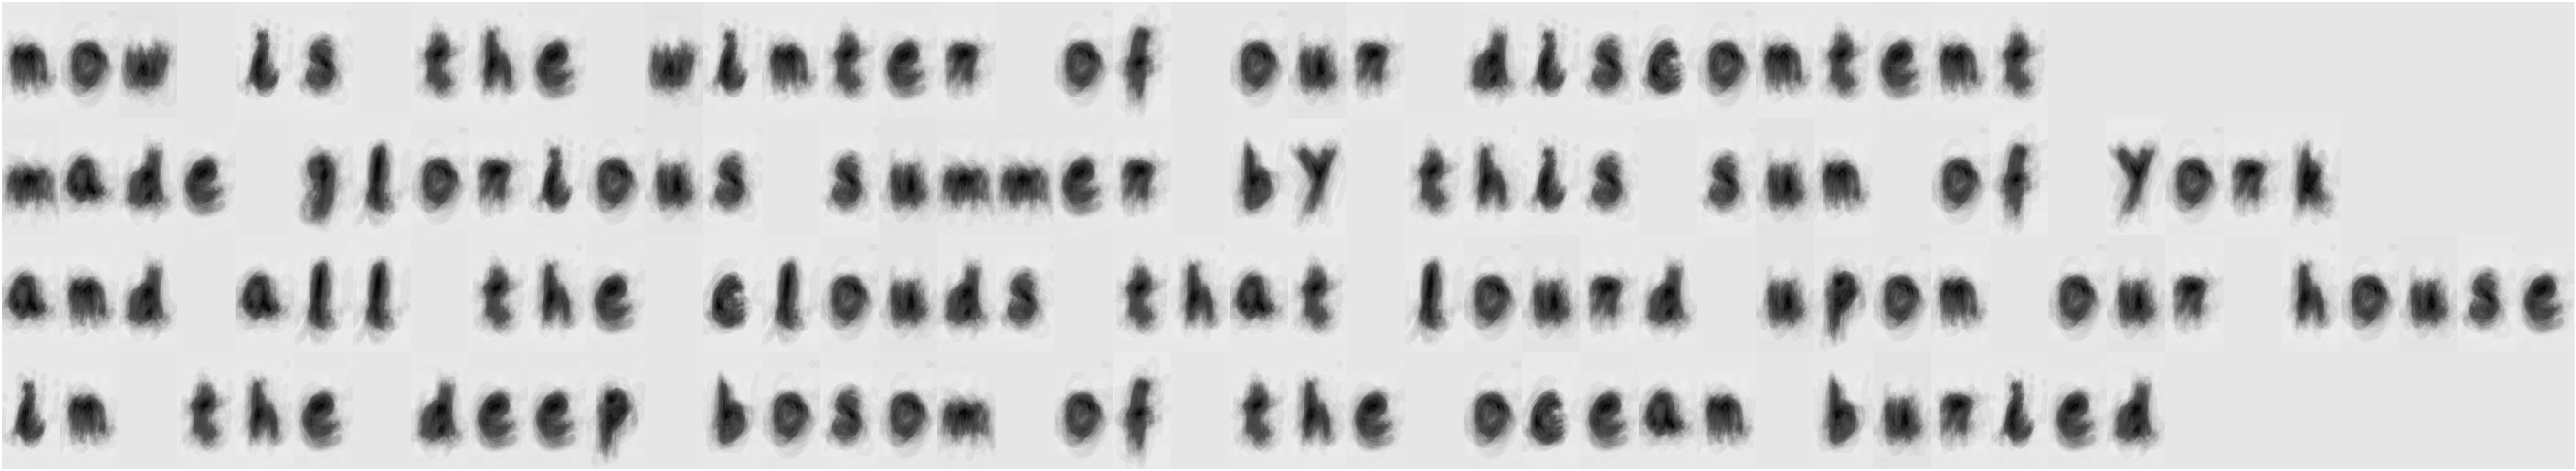

In [40]:
get_out_image("""Now is the winter of our discontent
Made glorious summer by this sun of York
And all the clouds that lourd upon our house
In the deep bosom of the ocean buried""", figsize=(200, 300))